<center>
  <h2>Trabajo Laboratorio de Implementación III - MCD Virtual Cohorte 2022</h2>
  <h3>Forecasting para una Empresa de Consumo Masivo</h3>
  <h4>Experimento 13 AutoGluon</h4>
</center>

In [1]:
# !pip install autogluon
# !pip install tslearn
# !pip install kmodes
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
import os
from sklearn.preprocessing import OneHotEncoder
from kmodes.kmodes import KModes
from sklearn.metrics import silhouette_score

### Lectura de datos

In [2]:
df_ventas_product = pd.read_csv("C:/Users/usuario/otros/Desktop/MCD/6 Labo III/Forecasting Problem/Datasets/df_ventas_product.csv", header = None)
df_ventas_product.columns = ["periodo", "product_id", "tn"]
df_ventas_product.head(5)

,periodo,product_id,tn
0,2017-01-01,20001,934.77222
1,2017-01-01,20002,550.15707
2,2017-01-01,20003,1063.45835
3,2017-01-01,20004,555.91614
4,2017-01-01,20005,494.27011


In [3]:
df_product = pd.read_csv("C:/Users/usuario/otros/Desktop/MCD/6 Labo III/Forecasting Problem/Datasets/df_products.csv", header = None)
df_product.columns = ["product_id", "cat1", "cat2", "cat3", "brand", "sku_size"]
df_product["sku_size"] = df_product["sku_size"].astype(str)
df_product.head(5)

,product_id,cat1,cat2,cat3,brand,sku_size
0,20280,HC,ROPA LAVADO,Liquido,LIMPIEX,900
1,20180,HC,ROPA LAVADO,Liquido,LIMPIEX,450
2,20332,HC,ROPA LAVADO,Liquido,LIMPIEX,120
3,20222,HC,ROPA LAVADO,Liquido,LIMPIEX,450
4,20288,HC,ROPA LAVADO,Liquido,LIMPIEX,900


### Clusters de SERIES DE TIEMPO

- Preprocesamiento para armado clusters

In [4]:
df_pivot = df_ventas_product.pivot(index='periodo',
                                   columns='product_id',
                                   values='tn')

print(df_pivot.shape, df_pivot.columns)
df_pivot.head(1)

(36, 780) Index([20001, 20002, 20003, 20004, 20005, 20006, 20007, 20008, 20009, 20010,
       ...
       21248, 21252, 21256, 21259, 21262, 21263, 21265, 21266, 21267, 21276],
      dtype='int64', name='product_id', length=780)


product_id,20001,20002,20003,20004,20005,20006,20007,20008,20009,20010,...,21248,21252,21256,21259,21262,21263,21265,21266,21267,21276
periodo,,,,,,,,,,,,,,,,,,,,,
2017-01-01,934.77222,550.15707,1063.45835,555.91614,494.27011,528.40996,464.67137,523.04609,378.08172,441.25546,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# resample time series data and fill missing values with 0s
df_pivot.index = pd.DatetimeIndex(df_pivot.index)
df_pivot = df_pivot.resample('MS').sum().fillna(0)
print(df_pivot.shape, df_pivot.columns)
df_pivot.head(1)

(36, 780) Index([20001, 20002, 20003, 20004, 20005, 20006, 20007, 20008, 20009, 20010,
       ...
       21248, 21252, 21256, 21259, 21262, 21263, 21265, 21266, 21267, 21276],
      dtype='int64', name='product_id', length=780)


product_id,20001,20002,20003,20004,20005,20006,20007,20008,20009,20010,...,21248,21252,21256,21259,21262,21263,21265,21266,21267,21276
periodo,,,,,,,,,,,,,,,,,,,,,
2017-01-01,934.77222,550.15707,1063.45835,555.91614,494.27011,528.40996,464.67137,523.04609,378.08172,441.25546,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# transpose data to match format neeed for further processing
df_pivoted = df_pivot.T
df_pivoted = df_pivoted.reset_index()
print(df_pivoted.shape, df_pivoted.columns)
df_pivoted.set_index('product_id', inplace=True)
df_pivoted.head(1)

(780, 37) Index([       'product_id', 2017-01-01 00:00:00, 2017-02-01 00:00:00,
       2017-03-01 00:00:00, 2017-04-01 00:00:00, 2017-05-01 00:00:00,
       2017-06-01 00:00:00, 2017-07-01 00:00:00, 2017-08-01 00:00:00,
       2017-09-01 00:00:00, 2017-10-01 00:00:00, 2017-11-01 00:00:00,
       2017-12-01 00:00:00, 2018-01-01 00:00:00, 2018-02-01 00:00:00,
       2018-03-01 00:00:00, 2018-04-01 00:00:00, 2018-05-01 00:00:00,
       2018-06-01 00:00:00, 2018-07-01 00:00:00, 2018-08-01 00:00:00,
       2018-09-01 00:00:00, 2018-10-01 00:00:00, 2018-11-01 00:00:00,
       2018-12-01 00:00:00, 2019-01-01 00:00:00, 2019-02-01 00:00:00,
       2019-03-01 00:00:00, 2019-04-01 00:00:00, 2019-05-01 00:00:00,
       2019-06-01 00:00:00, 2019-07-01 00:00:00, 2019-08-01 00:00:00,
       2019-09-01 00:00:00, 2019-10-01 00:00:00, 2019-11-01 00:00:00,
       2019-12-01 00:00:00],
      dtype='object', name='periodo')


periodo,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,...,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01
product_id,,,,,,,,,,,,,,,,,,,,,
20001,934.77222,798.0162,1303.35771,1069.9613,1502.20132,1520.06539,1030.67391,1267.39462,1316.94604,1439.75563,...,1470.65653,1647.63848,1629.78233,1109.93769,1678.99318,1261.34529,1660.00561,1561.50552,1397.37231,1504.68856


In [7]:
%%time
# convert dataframe to time_series_dataset
X = to_time_series_dataset(df_pivoted.values)
# normalize time series to zero mean and unit variance
X_train = TimeSeriesScalerMeanVariance().fit_transform(X)
print(X.shape, X_train.shape)

(780, 36, 1) (780, 36, 1)
CPU times: total: 344 ms
Wall time: 336 ms


In [8]:
# create required directory structure
dir_paths = ['./tsl_LABO', './tsl_LABO/models', './tsl_LABO/plots']
for dir_path in dir_paths:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

In [9]:
%%time
# algorithm configuration
algo = "DTW_kmeans"
metric = "dtw"
# cluster configuration
N_CLUSTERS = 20

model= TimeSeriesKMeans(n_clusters=N_CLUSTERS,
                        metric=metric,
                        n_jobs=-1,
                        random_state=0)
y_pred = model.fit_predict(X_train)
model.to_pickle(f"./tsl_LABO/models/{algo}.pkl")

CPU times: total: 2min 49s
Wall time: 2min 27s


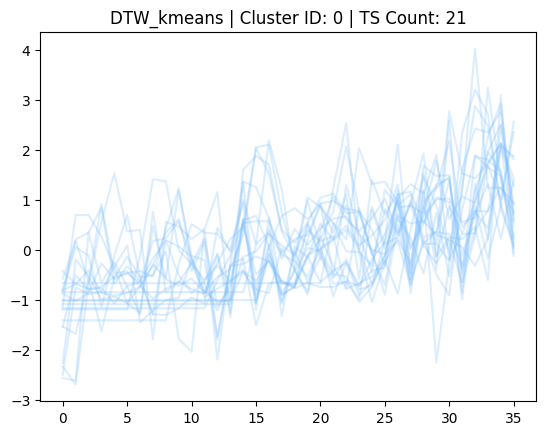

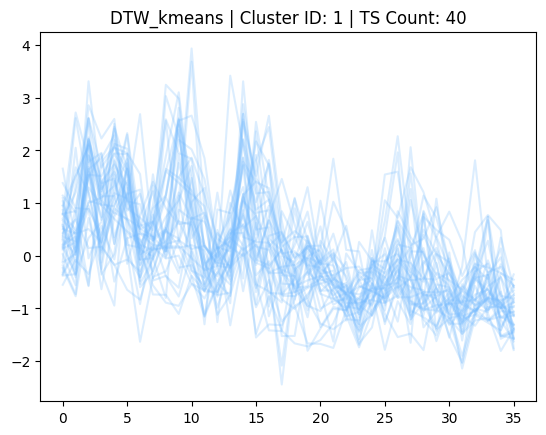

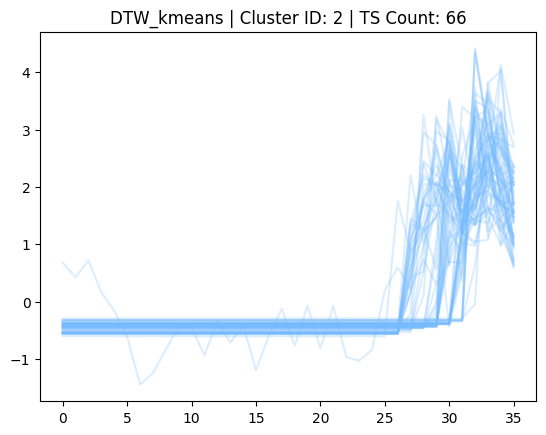

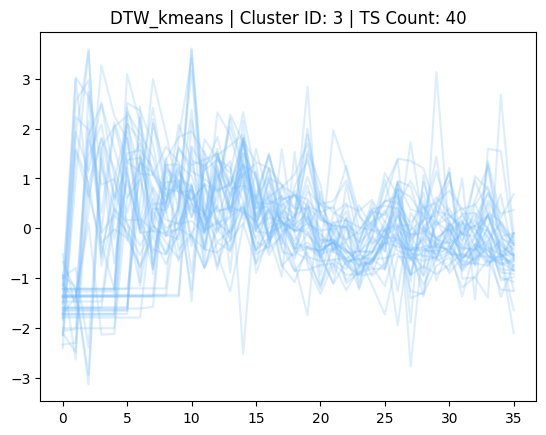

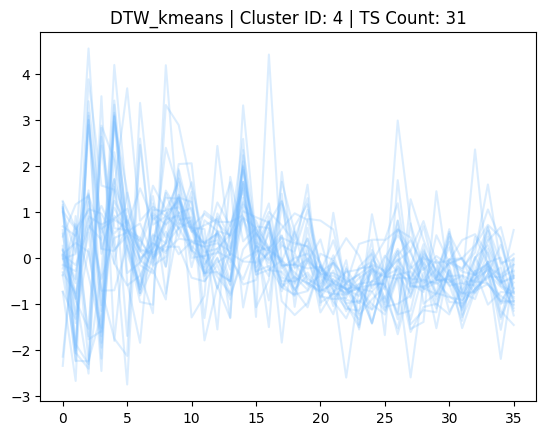

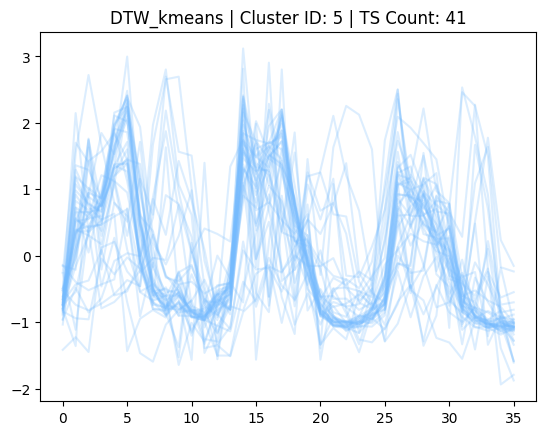

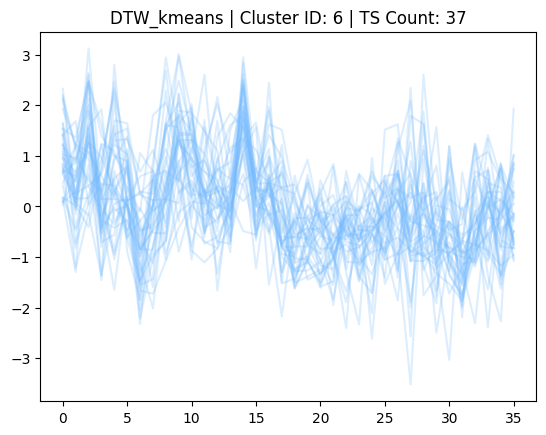

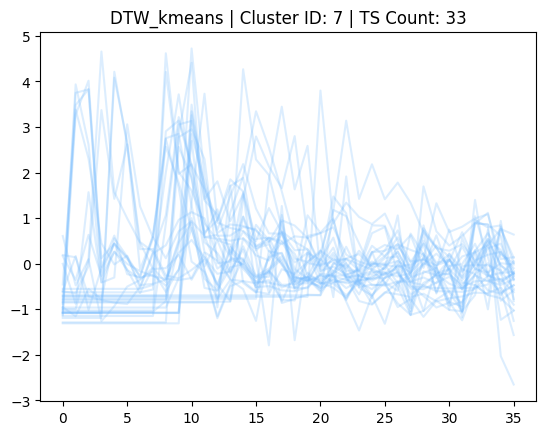

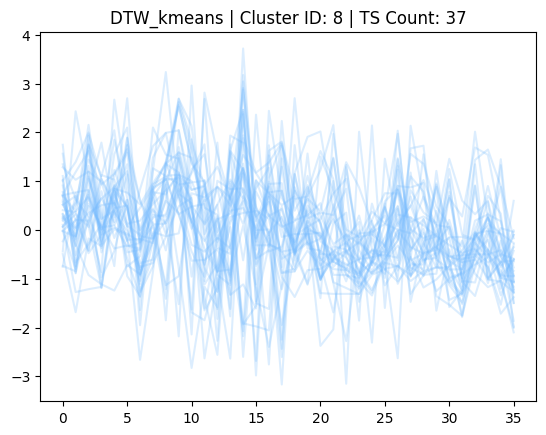

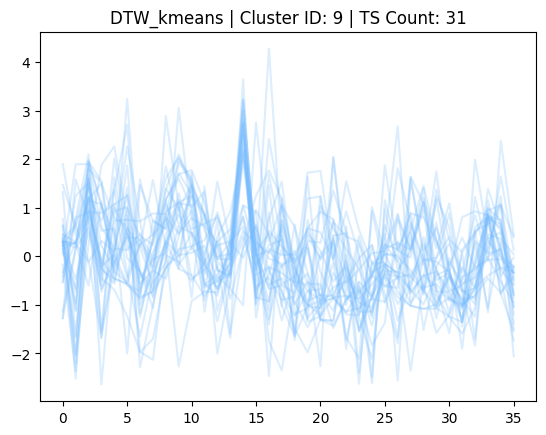

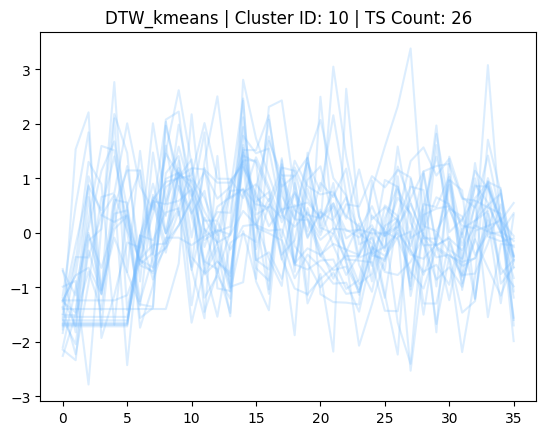

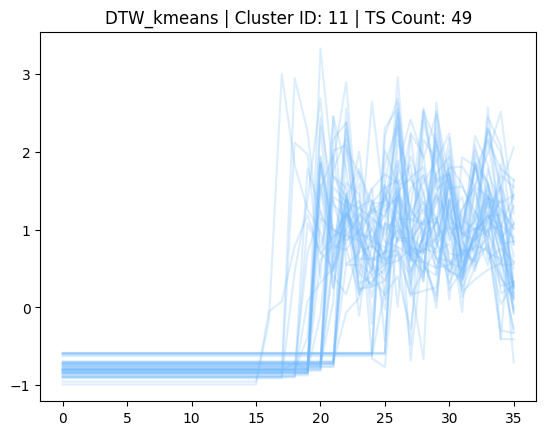

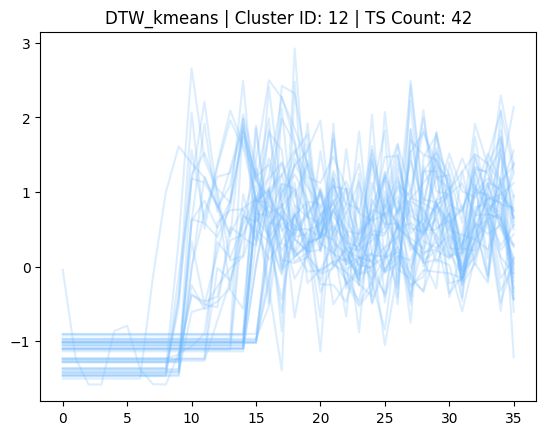

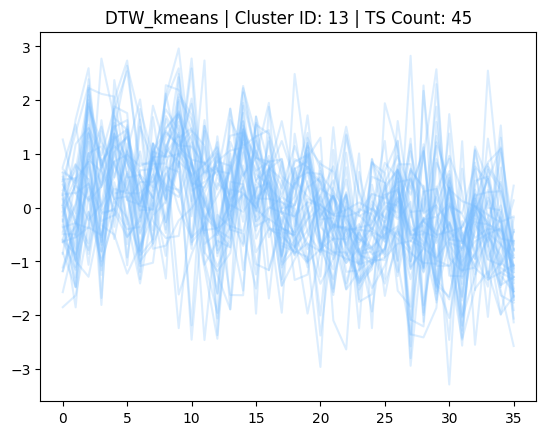

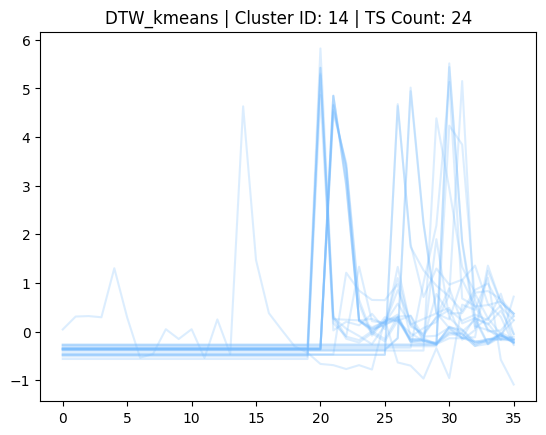

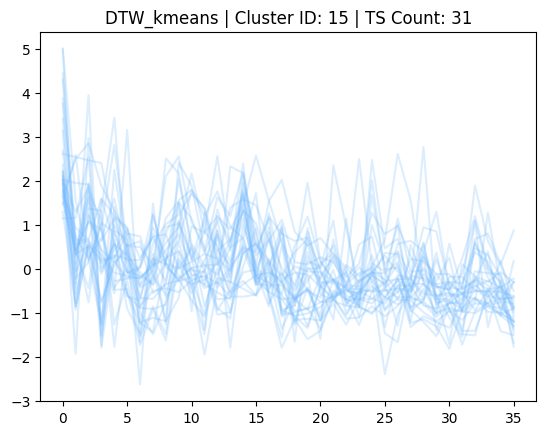

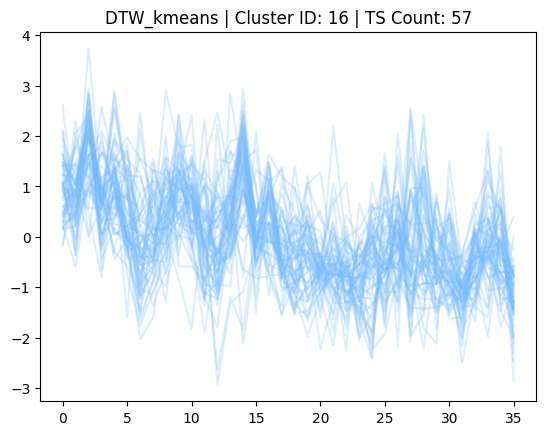

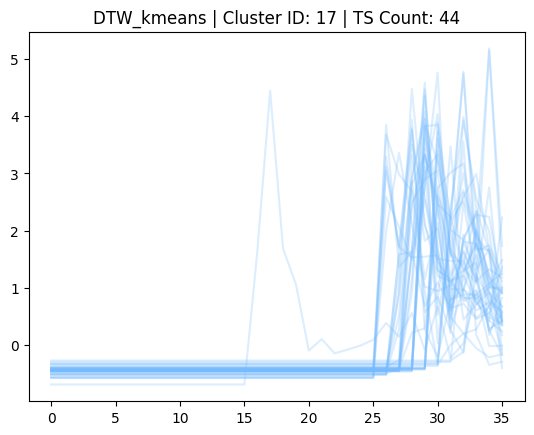

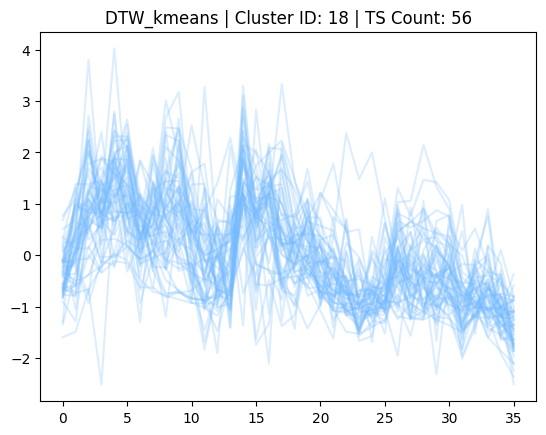

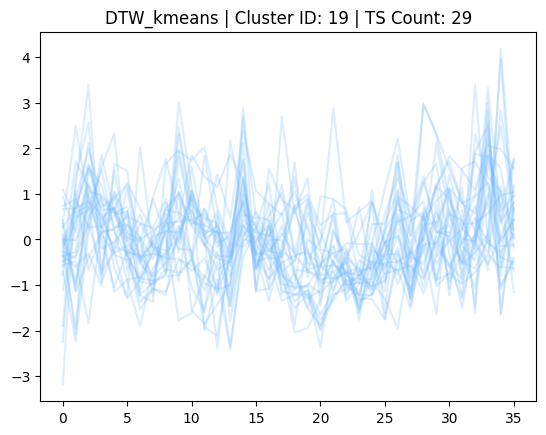

CPU times: total: 3.08 s
Wall time: 3.49 s


In [10]:
%%time

for yi in range(N_CLUSTERS):
    X_sub = X_train[y_pred == yi]
    ts_cnt = pd.Series(y_pred[y_pred == yi]).shape[0]
    fig = plt.figure()
    plt.title(f"{algo} | Cluster ID: {yi} | TS Count: {ts_cnt}")
    for xx in X_sub:
        plt.plot(xx.ravel(), color='xkcd:sky blue', alpha=0.25)
    # fig.savefig(f"./tsl_LABO/plots/{algo}_cls_lbl_{yi}.png", dpi=150)
    plt.show()
    plt.close()

In [11]:
len(df_pivoted)

780

In [12]:
len(y_pred)

780

In [13]:
df_pivoted_extended = pd.concat([df_pivoted.reset_index(), pd.DataFrame(y_pred, columns = ["cluster_id"])], axis = 1)
df_pivoted_extended

,product_id,2017-01-01 00:00:00,2017-02-01 00:00:00,2017-03-01 00:00:00,2017-04-01 00:00:00,2017-05-01 00:00:00,2017-06-01 00:00:00,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,...,2019-04-01 00:00:00,2019-05-01 00:00:00,2019-06-01 00:00:00,2019-07-01 00:00:00,2019-08-01 00:00:00,2019-09-01 00:00:00,2019-10-01 00:00:00,2019-11-01 00:00:00,2019-12-01 00:00:00,cluster_id
0,20001,934.77222,798.01620,1303.35771,1069.96130,1502.20132,1520.06539,1030.67391,1267.39462,1316.94604,...,1647.63848,1629.78233,1109.93769,1678.99318,1261.34529,1660.00561,1561.50552,1397.37231,1504.68856,10
1,20002,550.15707,505.88633,834.73521,522.35365,843.43785,968.15756,845.39319,619.71078,1065.34529,...,1287.62346,1034.98927,928.36431,1066.44999,813.78215,1090.18771,1979.53635,1423.57739,1087.30855,0
2,20003,1063.45835,752.11520,917.16548,525.82591,620.48202,744.08829,785.12398,864.21928,1465.83347,...,565.33774,590.12515,662.38654,715.20314,635.59563,967.77116,1081.36645,948.29393,892.50129,7
3,20004,555.91614,508.20044,489.91328,512.05402,543.36670,590.50779,569.88117,1042.52979,1259.64560,...,466.70901,603.31081,667.19411,521.71519,482.13372,786.17140,1064.69633,723.94206,637.90002,5
4,20005,494.27011,551.43060,563.89955,662.59032,515.58711,528.58883,625.84925,1068.01865,1247.88880,...,624.99880,897.26297,876.39696,745.74978,536.66800,879.52808,996.78275,606.91173,593.24443,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,21263,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.01835,0.02258,0.00988,0.03387,0.03388,0.01128,0.01552,0.03247,0.01270,14
776,21265,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.36405,0.17635,0.05121,0.02959,0.01593,0.01707,0.10921,0.06600,0.05007,14
777,21266,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.36178,0.17634,0.05235,0.05916,0.01480,0.02844,0.11831,0.06713,0.05121,14
778,21267,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.12291,0.24451,0.05882,0.07452,0.04054,0.01830,0.09676,0.04052,0.01569,17


In [14]:
df_tts = pd.melt(df_pivoted_extended, id_vars=['product_id', 'cluster_id'])
df_tts.columns = ['product_id', 'cluster_id', 'periodo', 'tn']
df_tts = df_tts[['periodo', 'product_id', 'cluster_id', 'tn']]
df_tts

,periodo,product_id,cluster_id,tn
0,2017-01-01 00:00:00,20001,10,934.77222
1,2017-01-01 00:00:00,20002,0,550.15707
2,2017-01-01 00:00:00,20003,7,1063.45835
3,2017-01-01 00:00:00,20004,5,555.91614
4,2017-01-01 00:00:00,20005,5,494.27011
...,...,...,...,...
28075,2019-12-01 00:00:00,21263,14,0.01270
28076,2019-12-01 00:00:00,21265,14,0.05007
28077,2019-12-01 00:00:00,21266,14,0.05121
28078,2019-12-01 00:00:00,21267,17,0.01569


In [15]:
len(df_tts[df_tts.tn != 0]) == len(df_ventas_product)
# df_tts tiene más registros porque las fechas sin tn por serie fueron completados con 0

True

In [16]:
df_tts.tn.sum()

1122605.2173000001

In [17]:
df_ventas_product.tn.sum()

1122605.2173000001

In [18]:
clusters_series = df_tts[["product_id", "cluster_id"]].drop_duplicates()
clusters_series

,product_id,cluster_id
0,20001,10
1,20002,0
2,20003,7
3,20004,5
4,20005,5
...,...,...
775,21263,14
776,21265,14
777,21266,14
778,21267,17


In [19]:
clusters_series.cluster_id.value_counts()

cluster_id
2     66
16    57
18    56
11    49
13    45
17    44
12    42
5     41
1     40
3     40
6     37
8     37
7     33
9     31
4     31
15    31
19    29
10    26
14    24
0     21
Name: count, dtype: int64

### Cluster general de PRODUCTOS, agregando clusters de SERIES

In [20]:
df_product_cluster = pd.merge(df_product, clusters_series, how = "inner", on = "product_id")
df_product_cluster["cluster_id"] = df_product_cluster["cluster_id"].astype(str)
df_product_cluster.dtypes

product_id     int64
cat1          object
cat2          object
cat3          object
brand         object
sku_size      object
cluster_id    object
dtype: object

In [21]:
df_product_cluster.head(5)

,product_id,cat1,cat2,cat3,brand,sku_size,cluster_id
0,20280,HC,ROPA LAVADO,Liquido,LIMPIEX,900,8
1,20180,HC,ROPA LAVADO,Liquido,LIMPIEX,450,8
2,20332,HC,ROPA LAVADO,Liquido,LIMPIEX,120,8
3,20222,HC,ROPA LAVADO,Liquido,LIMPIEX,450,13
4,20288,HC,ROPA LAVADO,Liquido,LIMPIEX,900,6


In [22]:
# Seleccionar las características categóricas
categorical_features = ['cat1', 'cat2', 'cat3', 'brand', 'sku_size', 'cluster_id']
# Aplicar One-Hot Encoding
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(df_product_cluster[categorical_features])
# Convertir a DataFrame
encoded_df = pd.DataFrame(encoded_features.toarray(), columns=encoder.get_feature_names_out(categorical_features))
# Añadir de nuevo el product_id para referencia
encoded_df['product_id'] = df_product_cluster['product_id'].values
encoded_df.head(5)

,cat1_FOODS,cat1_HC,cat1_PC,cat1_REF,cat2_ADEREZOS,cat2_CABELLO,cat2_DENTAL,cat2_DEOS,cat2_HOGAR,cat2_OTROS,...,cluster_id_19,cluster_id_2,cluster_id_3,cluster_id_4,cluster_id_5,cluster_id_6,cluster_id_7,cluster_id_8,cluster_id_9,product_id
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,20280
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,20180
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,20332
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20222
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,20288


In [23]:
# Ajustar el modelo con el número óptimo de clusters 
n_clusters_optimo = 30

km_optimo = KModes(n_clusters=n_clusters_optimo, init='Huang', n_init=5, verbose=1)
clusters_optimos = km_optimo.fit_predict(encoded_df.drop('product_id', axis=1))

# Añadir los clusters óptimos al DataFrame original
df_product_cluster['cluster'] = clusters_optimos

# Ver el DataFrame con los clusters óptimos
df_product_cluster.head()

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 198, cost: 2507.0
Run 1, iteration: 2/100, moves: 46, cost: 2486.0
Run 1, iteration: 3/100, moves: 13, cost: 2485.0
Run 1, iteration: 4/100, moves: 0, cost: 2485.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 154, cost: 2438.0
Run 2, iteration: 2/100, moves: 30, cost: 2428.0
Run 2, iteration: 3/100, moves: 0, cost: 2428.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 189, cost: 2603.0
Run 3, iteration: 2/100, moves: 34, cost: 2593.0
Run 3, iteration: 3/100, moves: 0, cost: 2593.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 236, cost: 2685.0
Run 4, iteration: 2/100, moves: 21, cost: 2674.0
Run 4, iteration: 3/100, moves: 0, cost: 2674.0
Init: initializing centroids
Init: initiali

,product_id,cat1,cat2,cat3,brand,sku_size,cluster_id,cluster
0,20280,HC,ROPA LAVADO,Liquido,LIMPIEX,900,8,9
1,20180,HC,ROPA LAVADO,Liquido,LIMPIEX,450,8,9
2,20332,HC,ROPA LAVADO,Liquido,LIMPIEX,120,8,9
3,20222,HC,ROPA LAVADO,Liquido,LIMPIEX,450,13,9
4,20288,HC,ROPA LAVADO,Liquido,LIMPIEX,900,6,9


In [24]:
df_product_cluster = df_product_cluster[["product_id", "cluster"]]
df_product_cluster.groupby(["cluster"])["product_id"].nunique()

cluster
0     42
1     58
2     19
3     28
4     46
5     65
6     74
7     43
8     14
9     39
10     6
11    17
12    75
13     6
14    34
15     7
16     2
17    39
18     4
19    22
20     6
21     6
22    14
23    15
24     2
25     7
26    13
27     4
28    14
29    59
Name: product_id, dtype: int64

### Modelado

In [25]:
df = pd.merge(df_ventas_product, df_product_cluster, how = "left", on = "product_id")
df

,periodo,product_id,tn,cluster
0,2017-01-01,20001,934.77222,9
1,2017-01-01,20002,550.15707,9
2,2017-01-01,20003,1063.45835,1
3,2017-01-01,20004,555.91614,1
4,2017-01-01,20005,494.27011,1
...,...,...,...,...
22344,2019-12-01,21263,0.01270,25
22345,2019-12-01,21265,0.05007,14
22346,2019-12-01,21266,0.05121,14
22347,2019-12-01,21267,0.01569,6


In [26]:
N_CLUSTERS = n_clusters_optimo

# Crear un bucle for que itere sobre cada cluster_id
for cluster_id in range(N_CLUSTERS):
    # Filtrar el dataframe original df_tts por el cluster_id actual
    df_cluster = df[df.cluster == cluster_id]
    # Eliminar la columna "cluster_id" del dataframe filtrado
    df_cluster = df_cluster.drop(columns={"cluster"})
    # Imprimir información sobre el cluster actual
    print(f"---------------C{cluster_id}---------------")
    print(df_cluster.periodo.min(), df_cluster.periodo.max())
    print(len(df_cluster.drop_duplicates(subset="product_id")))
    # Asignar el dataframe resultante a una variable específica para cada cluster (opcional)
    globals()[f"df_ventas_product_cluster{cluster_id}"] = df_cluster

---------------C0---------------
2017-01-01 2019-12-01
42
---------------C1---------------
2017-01-01 2019-12-01
58
---------------C2---------------
2017-01-01 2019-12-01
19
---------------C3---------------
2017-01-01 2019-12-01
28
---------------C4---------------
2017-01-01 2019-12-01
46
---------------C5---------------
2017-01-01 2019-12-01
65
---------------C6---------------
2017-01-01 2019-12-01
74
---------------C7---------------
2017-01-01 2019-12-01
43
---------------C8---------------
2017-01-01 2019-12-01
14
---------------C9---------------
2017-01-01 2019-12-01
39
---------------C10---------------
2017-01-01 2019-12-01
6
---------------C11---------------
2017-01-01 2019-12-01
17
---------------C12---------------
2017-01-01 2019-12-01
75
---------------C13---------------
2019-04-01 2019-12-01
6
---------------C14---------------
2017-01-01 2019-12-01
34
---------------C15---------------
2017-01-01 2019-12-01
7
---------------C16---------------
2017-05-01 2019-12-01
2
-----------

In [27]:
total_productos_unicos = 0

# Crear un bucle for que itere sobre cada cluster_id
for cluster_id in range(N_CLUSTERS):
    # Obtener el nombre de la variable del dataframe del cluster actual
    df_name = f"df_ventas_product_cluster{cluster_id}"
    
    # Verificar si la variable existe en el entorno global
    if df_name in globals():
        # Obtener el dataframe del cluster actual
        df_cluster = globals()[df_name]
        
        # Calcular la cantidad de productos únicos en el cluster actual
        productos_unicos = len(df_cluster.drop_duplicates(subset="product_id"))
        
        # Sumar al total de productos únicos
        total_productos_unicos += productos_unicos

# Imprimir el total de productos únicos en todos los clusters
print("Total de productos únicos en todos los clusters:", total_productos_unicos)

Total de productos únicos en todos los clusters: 780


In [28]:
# Crear un bucle for que itere sobre cada cluster_id
for cluster_id in range(N_CLUSTERS):
    # Construir el nombre de la variable del dataframe del cluster actual
    df_name = f"df_ventas_product_cluster{cluster_id}"
    
    # Verificar si la variable existe en el entorno global
    if df_name in globals():
        # Obtener el dataframe del cluster actual
        df_cluster = globals()[df_name]
        
        # Renombrar las columnas especificadas en el dataframe del cluster actual
        df_cluster = df_cluster.rename(columns={"periodo": "timestamp", "product_id": "item_id", "tn": "target"})
        
        # Asignar el dataframe renombrado de vuelta a la variable global
        globals()[df_name] = df_cluster

In [29]:
df_ventas_product_cluster0.head(1)

,timestamp,item_id,target
93,2017-01-01,20111,68.00977


In [30]:
df_ventas_product_cluster9.head(1)

,timestamp,item_id,target
0,2017-01-01,20001,934.77222


In [31]:
# Lista para almacenar los objetos TimeSeriesDataFrame
time_series_dataframes = []

# Crear un bucle for que itere sobre cada cluster_id
for cluster_id in range(N_CLUSTERS):
    # Construir el nombre de la variable del dataframe del cluster actual
    df_name = f"df_ventas_product_cluster{cluster_id}"
    
    # Verificar si la variable existe en el entorno actual (recomendado usar locals())
    if df_name in locals():
        # Obtener el dataframe del cluster actual
        df_cluster = locals()[df_name]
        # Crear un objeto TimeSeriesDataFrame con el dataframe actual
        data = TimeSeriesDataFrame(df_cluster)
        # Agregar el objeto TimeSeriesDataFrame a la lista
        time_series_dataframes.append(data)
        # Opcional: Asignar el objeto a una variable individual si es necesario
        globals()[f"data{cluster_id}"] = data

In [32]:
predictors = []
for cluster_id in range(N_CLUSTERS):
    print(f"PREDICTOR {cluster_id}")
    data = globals()[f"data{cluster_id}"]  # Assuming data variables are named as data0, data1, ..., data9
    predictor = TimeSeriesPredictor(target='target', prediction_length=2, freq="M").fit(data, num_val_windows = 3)
    predictors.append(predictor)

Frequency 'M' stored as 'ME'
Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels\ag-20240703_133247'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.11.2
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          8
GPU Count:          0
Memory Avail:       2.09 GB / 7.88 GB (26.5%)
Disk Space Avail:   10.81 GB / 110.21 GB (9.8%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'ME',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 2,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'verbosity': 2}

train_data with frequency 'None' has been resampled to frequency 'ME'.


PREDICTOR 0


Provided train_data has 1043 rows (NaN fraction=0.3%), 42 time series. Median time series length is 30 (min=4, max=36). 
	Removing 11 short time series from train_data. Only series with length >= 11 will be used for training.
	After filtering, train_data has 960 rows (NaN fraction=0.3%), 31 time series. Median time series length is 36 (min=15, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-03 10:32:48
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.2251       = Validation score (-WQL)
	3.04  

PREDICTOR 1


Provided train_data has 1666 rows, 58 time series. Median time series length is 36 (min=4, max=36). 
	Removing 7 short time series from train_data. Only series with length >= 11 will be used for training.
	After filtering, train_data has 1633 rows, 51 time series. Median time series length is 36 (min=14, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-03 10:52:53
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.2281       = Validation score (-WQL)
	3.54    s     = Training runtime
	0.07    s   

PREDICTOR 2


Provided train_data has 583 rows, 19 time series. Median time series length is 36 (min=5, max=36). 
	Removing 2 short time series from train_data. Only series with length >= 11 will be used for training.
	After filtering, train_data has 573 rows, 17 time series. Median time series length is 36 (min=14, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-03 11:18:09
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.3441       = Validation score (-WQL)
	3.38    s     = Training runtime
	0.04    s     

PREDICTOR 3


Provided train_data has 772 rows (NaN fraction=0.4%), 28 time series. Median time series length is 36 (min=5, max=36). 
	Removing 4 short time series from train_data. Only series with length >= 11 will be used for training.
	After filtering, train_data has 747 rows (NaN fraction=0.4%), 24 time series. Median time series length is 36 (min=20, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-03 11:37:04
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.2469       = Validation score (-WQL)
	3.50    

PREDICTOR 4


Provided train_data has 1490 rows (NaN fraction=0.3%), 46 time series. Median time series length is 36 (min=8, max=36). 
	Removing 4 short time series from train_data. Only series with length >= 11 will be used for training.
	After filtering, train_data has 1456 rows (NaN fraction=0.3%), 42 time series. Median time series length is 36 (min=14, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-03 11:55:42
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.2961       = Validation score (-WQL)
	4.52  

PREDICTOR 5


Provided train_data has 1973 rows (NaN fraction=0.1%), 65 time series. Median time series length is 36 (min=5, max=36). 
	Removing 8 short time series from train_data. Only series with length >= 11 will be used for training.
	After filtering, train_data has 1910 rows (NaN fraction=0.1%), 57 time series. Median time series length is 36 (min=16, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-03 12:17:35
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.2630       = Validation score (-WQL)
	3.40  

PREDICTOR 6


Provided train_data has 1868 rows (NaN fraction=0.2%), 74 time series. Median time series length is 30 (min=4, max=36). 
	Removing 17 short time series from train_data. Only series with length >= 11 will be used for training.
	After filtering, train_data has 1762 rows (NaN fraction=0.2%), 57 time series. Median time series length is 36 (min=11, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-03 12:38:24
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.2439       = Validation score (-WQL)
	3.45 

PREDICTOR 7


Provided train_data has 1019 rows (NaN fraction=0.1%), 43 time series. Median time series length is 27 (min=7, max=36). 
	Removing 13 short time series from train_data. Only series with length >= 11 will be used for training.
	After filtering, train_data has 914 rows (NaN fraction=0.1%), 30 time series. Median time series length is 36 (min=15, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-03 12:57:49
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.2113       = Validation score (-WQL)
	3.53  

PREDICTOR 8


Provided train_data has 453 rows, 14 time series. Median time series length is 36 (min=15, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-03 13:16:32
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.4513       = Validation score (-WQL)
	4.52    s     = Training runtime
	0.04    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. 
	Time series in the dataset are too short for chosen differences [12]. Setting differences to [1].
	Time series in the dataset are too

PREDICTOR 9


Provided train_data has 1029 rows (NaN fraction=0.1%), 39 time series. Median time series length is 36 (min=4, max=36). 
	Removing 7 short time series from train_data. Only series with length >= 11 will be used for training.
	After filtering, train_data has 988 rows (NaN fraction=0.1%), 32 time series. Median time series length is 36 (min=11, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-03 13:35:55
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.2199       = Validation score (-WQL)
	3.78   

PREDICTOR 10


Provided train_data has 216 rows (NaN fraction=0.5%), 6 time series. Median time series length is 36 (min=36, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-03 13:57:34
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-1.0530       = Validation score (-WQL)
	3.23    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. 
	-1.0269       = Validation score (-WQL)
	6.63    s     = Training runtime
	0.07    s     = Validation (prediction)

PREDICTOR 11


Provided train_data has 584 rows, 17 time series. Median time series length is 36 (min=9, max=36). 
	Removing 1 short time series from train_data. Only series with length >= 11 will be used for training.
	After filtering, train_data has 575 rows, 16 time series. Median time series length is 36 (min=35, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-03 14:16:30
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.2709       = Validation score (-WQL)
	3.15    s     = Training runtime
	0.05    s     

PREDICTOR 12


Provided train_data has 2249 rows, 75 time series. Median time series length is 36 (min=8, max=36). 
	Removing 10 short time series from train_data. Only series with length >= 11 will be used for training.
	After filtering, train_data has 2157 rows, 65 time series. Median time series length is 36 (min=15, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-03 14:35:31
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.2194       = Validation score (-WQL)
	6.45    s     = Training runtime
	0.11    s  

PREDICTOR 13


Provided train_data has 38 rows, 6 time series. Median time series length is 5 (min=5, max=9). 
Time series in train_data are too short for chosen num_val_windows=3. Reducing num_val_windows to 1.
	Removing 4 short time series from train_data. Only series with length >= 7 will be used for training.
	After filtering, train_data has 18 rows, 2 time series. Median time series length is 9 (min=9, max=9). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-03 15:09:02
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 

PREDICTOR 14


Provided train_data has 935 rows (NaN fraction=0.2%), 34 time series. Median time series length is 36 (min=6, max=36). 
	Removing 7 short time series from train_data. Only series with length >= 11 will be used for training.
	After filtering, train_data has 878 rows (NaN fraction=0.2%), 27 time series. Median time series length is 36 (min=16, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-03 15:14:51
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.3334       = Validation score (-WQL)
	3.25    

PREDICTOR 15


train_data with frequency 'MS' has been resampled to frequency 'ME'.
Provided train_data has 252 rows, 7 time series. Median time series length is 36 (min=36, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-03 15:32:35
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.5977       = Validation score (-WQL)
	3.10    s     = Training runtime
	0.04    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. 
	-0.5804       = Validation score (-WQL)
	5.52    s     = Training

PREDICTOR 16


train_data with frequency 'MS' has been resampled to frequency 'ME'.
Provided train_data has 64 rows, 2 time series. Median time series length is 32 (min=32, max=32). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-03 15:52:52
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.5996       = Validation score (-WQL)
	4.45    s     = Training runtime
	0.02    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. 
	-0.6818       = Validation score (-WQL)
	4.02    s     = Training 

PREDICTOR 17


train_data with frequency 'MS' has been resampled to frequency 'ME'.
Provided train_data has 1039 rows, 39 time series. Median time series length is 36 (min=9, max=36). 
	Removing 8 short time series from train_data. Only series with length >= 11 will be used for training.
	After filtering, train_data has 966 rows, 31 time series. Median time series length is 36 (min=14, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-03 16:10:25
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.2716       = Val

PREDICTOR 18


train_data with frequency 'MS' has been resampled to frequency 'ME'.
Provided train_data has 144 rows, 4 time series. Median time series length is 36 (min=36, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-03 16:30:59
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.7277       = Validation score (-WQL)
	3.54    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. 
	-0.6471       = Validation score (-WQL)
	5.99    s     = Training

PREDICTOR 19


Provided train_data has 792 rows, 22 time series. Median time series length is 36 (min=36, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-03 16:48:41
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.8217       = Validation score (-WQL)
	3.78    s     = Training runtime
	0.05    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. 
	-0.6642       = Validation score (-WQL)
	8.87    s     = Training runtime
	0.09    s     = Validation (prediction) runtime
Training t

PREDICTOR 20


train_data with frequency 'MS' has been resampled to frequency 'ME'.
Provided train_data has 216 rows, 6 time series. Median time series length is 36 (min=36, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-03 17:12:43
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.2806       = Validation score (-WQL)
	5.50    s     = Training runtime
	0.02    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. 
	-0.2787       = Validation score (-WQL)
	6.59    s     = Training

PREDICTOR 21


train_data with frequency 'MS' has been resampled to frequency 'ME'.
Provided train_data has 158 rows, 6 time series. Median time series length is 36 (min=7, max=36). 
	Removing 2 short time series from train_data. Only series with length >= 11 will be used for training.
	After filtering, train_data has 144 rows, 4 time series. Median time series length is 36 (min=36, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-03 17:30:19
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.2594       = Valida

PREDICTOR 22


Provided train_data has 318 rows, 14 time series. Median time series length is 23 (min=4, max=36). 
	Removing 4 short time series from train_data. Only series with length >= 11 will be used for training.
	After filtering, train_data has 294 rows, 10 time series. Median time series length is 36 (min=16, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-03 17:53:58
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.1617       = Validation score (-WQL)
	3.72    s     = Training runtime
	0.04    s     

PREDICTOR 23


Provided train_data has 520 rows, 15 time series. Median time series length is 36 (min=27, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-03 18:11:32
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.3322       = Validation score (-WQL)
	3.78    s     = Training runtime
	0.05    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. 
	-0.3032       = Validation score (-WQL)
	9.90    s     = Training runtime
	0.10    s     = Validation (prediction) runtime
Training t

PREDICTOR 24


Provided train_data has 72 rows, 2 time series. Median time series length is 36 (min=36, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-03 18:33:46
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.2258       = Validation score (-WQL)
	5.10    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. 
	-0.2644       = Validation score (-WQL)
	3.34    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training tim

PREDICTOR 25


Provided train_data has 105 rows, 7 time series. Median time series length is 15 (min=15, max=15). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-03 18:53:21
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-1.4268       = Validation score (-WQL)
	3.25    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. 
	Time series in the dataset are too short for chosen differences [12]. Setting differences to [1].
	Time series in the dataset are too 

PREDICTOR 26


train_data with frequency 'MS' has been resampled to frequency 'ME'.
Provided train_data has 392 rows, 13 time series. Median time series length is 36 (min=6, max=36). 
	Removing 1 short time series from train_data. Only series with length >= 11 will be used for training.
	After filtering, train_data has 386 rows, 12 time series. Median time series length is 36 (min=16, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-03 19:11:40
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.2291       = Vali

PREDICTOR 27


Provided train_data has 127 rows, 4 time series. Median time series length is 32 (min=27, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-03 19:30:19
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.1334       = Validation score (-WQL)
	3.01    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. 
	-0.1835       = Validation score (-WQL)
	3.64    s     = Training runtime
	0.08    s     = Validation (prediction) runtime
Training ti

PREDICTOR 28


Provided train_data has 261 rows (NaN fraction=1.1%), 14 time series. Median time series length is 22 (min=6, max=36). 
	Removing 4 short time series from train_data. Only series with length >= 11 will be used for training.
	After filtering, train_data has 235 rows (NaN fraction=1.3%), 10 time series. Median time series length is 22 (min=18, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-03 19:45:53
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.3273       = Validation score (-WQL)
	3.62    

PREDICTOR 29


Provided train_data has 1997 rows (NaN fraction=0.2%), 59 time series. Median time series length is 36 (min=10, max=36). 
	Removing 4 short time series from train_data. Only series with length >= 11 will be used for training.
	After filtering, train_data has 1957 rows (NaN fraction=0.2%), 55 time series. Median time series length is 36 (min=24, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-03 20:04:59
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.3067       = Validation score (-WQL)
	3.48 

In [36]:
predictions_list = []
for cluster_id in range(N_CLUSTERS):
    predictor = predictors[cluster_id]  # Accede al predictor correspondiente desde la lista
    data = globals()[f"data{cluster_id}"]  # Accede dinámicamente a los datos correspondientes
    predictions = predictor.predict(data)
    predictions_list.append(predictions)

# Concatenar todas las predicciones en un solo DataFrame
concatenated_predictions = pd.concat(predictions_list)

data with frequency 'None' has been resampled to frequency 'ME'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
data with frequency 'MS' has been resampled to frequency 'ME'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
data with frequency 'MS' has been resampled to frequency 'ME'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
data with frequency 'None' has been resampled to frequency 'ME'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
data with frequency 'None' has been resampled to frequency 'ME'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
data with frequency 'None' has been resampled to frequency 'ME'.
Model not specified in predict, will default to the model with the best validat

In [37]:
predictions_v1 = concatenated_predictions.copy()
predictions_v1 = predictions_v1.reset_index()
predictions_v1 = predictions_v1[["item_id", "timestamp", "mean"]]
predictions_v1 = predictions_v1[predictions_v1.timestamp == "2020-02-29"]
predictions_v1 = predictions_v1.drop(columns = {"timestamp"})
predictions_v1 = predictions_v1.rename(columns = {"item_id":"product_id", "mean":"tn"})
predictions_v1.head(5)

,product_id,tn
1,20111,86.709609
3,20263,24.626901
5,20267,24.676546
7,20321,26.531947
9,20367,12.831536


In [38]:
len(predictions_v1.product_id.unique())

780

In [39]:
predictions_v1.to_csv("C:/Users/usuario/otros/Desktop\MCD/6 Labo III/Forecasting Problem/Outputs/prediccion_autogluon_30cluster_products.csv", sep = ",", index = False)